In [250]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
#import osmnx as ox
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
#import sklearn as sk
#from pyro.infer import MCMC, NUTS, Predictive, SVI, TraceMeanField_ELBO,HMC
import torch
import random
from scipy import stats 
import seaborn as sns

In [252]:
# IMPORT DATA
data=pd.read_excel(r"\\192.168.1.59\UserFolders\michael.forsmann\Data\Seasonality_function\PM_all.xlsx")
#no2=pd.read_excel(r"\\192.168.1.59\UserFolders\michael.forsmann\Data\Seasonality_function\NO_All.xlsx")


In [253]:
no2=pd.read_excel(r"\\192.168.1.59\UserFolders\michael.forsmann\Data\Copsac_Private\Chemicals_corrected.xlsx")


In [254]:
pm=pd.read_excel(r"\\192.168.1.59\UserFolders\michael.forsmann\Data\Seasonality_function\PM2_5_polution.xlsx")


In [256]:
pm=pm.set_index(["maalnr","bnr"])
data=data.set_index(["maalnr","bnr"])
PM=pm.assign(passive=data.passive)
data=PM.reset_index()

In [257]:
# Defining plot for loss 
def plot_loss(loss,):
    plt.plot(loss)
    plt.xlabel("Iterations")
    _ = plt.ylabel("Loss")  # supress output text


In [258]:
data.sadto=pd.to_datetime(data.sadto)
data=data.assign(week=data.sadto.apply(lambda x: x.week))
data=data.assign(month=data.sadto.apply(lambda x: x.month))
data=data.assign(year=data.sadto.apply(lambda x: x.year))
data=data.assign(day=data.sadto.apply(lambda x: x.day_of_year))

In [259]:
# Extract week,dat
no2["sadto"]=pd.to_datetime(no2.start_n)
no2=no2.assign(week=no2.sadto.apply(lambda x: x.week))
no2=no2.assign(month=no2.sadto.apply(lambda x: x.month))
no2=no2.assign(year=no2.sadto.apply(lambda x: x.year))
no2=no2.assign(day=no2.sadto.apply(lambda x: x.day_of_year))

In [261]:
#removeig unwanted stuff

no2=no2.replace(",",".",regex=True).rename(columns={"no2_(μg/m3)":"no2","no_(μg/m3)":"Nox","formald_(μg/m3)":"formaldehyd","acetald_(μg/m3)":"acetald","acetone_(μg/m3)":"acetone"})
no2.no2=no2.no2.astype(float)
no2.Nox=no2.Nox.astype(float)

In [404]:
no2.loc[no2.cpnr==1]

,Unnamed: 0,cpnr,visit,batch_c,start_c,stop_c,batch_n,start_n,stop_n,no2,...,sample_time,day,Nox,no2_corrected,formaldehyd_corrected,sadto,week,month,year,10_week
0,0,1,1,Batch1,1999-09-02,1999-11-04,Batch 2,1999-04-20,1999-07-04,7.8,...,75,110,NaN,7.996002,19.366838,1999-04-20,16,4,1999,15.714286
1,1,1,?,NaN,NaT,NaT,Batch 7,1999-09-21,1999-11-04,6.8,...,44,264,NaN,5.976705,NaN,1999-09-21,38,9,1999,37.714286
2,2,1,1yr,Batch4,2000-03-21,2000-05-26,Batch 11,2000-03-16,2000-05-26,6.5,...,71,76,NaN,6.532343,14.787594,2000-03-16,11,3,2000,10.857143
3,3,1,18mdr,Batch28,2001-06-20,2001-09-10,Batch 45,2001-06-20,2001-09-10,11.6,...,82,171,NaN,12.311922,18.872279,2001-06-20,25,6,2001,24.428571


In [406]:
no2.loc[no2.visit=="6mdr","visit"]=1
no2.loc[no2.visit=="1yr","visit"]=2
no2.loc[no2.visit=="18mdr","visit"]=3
no2.loc[no2.visit=="2yr","visit"]=4
no2.loc[no2.visit=="30mdr","visit"]=5
no2.loc[no2.visit==18,"visit"]=5
no2.loc[no2.visit=="?","visit"]=4

In [408]:

def plot(
    plot_observed_data=False,
    plot_predictions=False,
    n_prior_samples=0,
    model=None,
    kernel=None,
    n_test=500,
    ax=None,
    maxx=12
):

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    if plot_observed_data:
        ax.plot(X.numpy(), y.numpy(), "kx")
    if plot_predictions:
        Xtest = torch.linspace(-0.1,maxx, n_test)  # test inputs
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP:
                mean, cov = model(Xtest, full_cov=True)
            else:
                mean, cov = model(Xtest, full_cov=True, noiseless=False)
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        ax.plot(Xtest.numpy(), mean.numpy(), "r", lw=2)  # plot the mean
        ax.fill_between(
            Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
            (mean - 2.0 * sd).numpy(),
            (mean + 2.0 * sd).numpy(),
            color="C0",
            alpha=0.3,
        )
    if n_prior_samples > 0:  # plot samples from the GP prior
        Xtest = torch.linspace(-0.1,maxx, n_test)  # test inputs
        noise = (
            model.noise
            if type(model) != gp.models.VariationalSparseGP
            else model.likelihood.variance
        )
        cov = kernel.forward(Xtest) + noise.expand(n_test).diag()
        samples = dist.MultivariateNormal(
            torch.zeros(n_test), covariance_matrix=cov
        ).sample(sample_shape=(n_prior_samples,))
        ax.plot(Xtest.numpy(), samples.numpy().T, lw=2, alpha=0.4)

    ax.set_xlim(-0.1,maxx)


## PM2.5

In [272]:
data["corrected_week"]=data.day/7
data=data.loc[data.corrected_pm25.isna()==0]
data_train=data.loc[data.passive==0]=data.loc[data.passive==0]
data_test=data.loc[data.passive!=0]

In [275]:

 torch.tensor(data_train.corrected_week.std()**2)

tensor(230.7016)

In [277]:
#resetting  kernal parameters
pyro.clear_param_store()
#defning kernal
rbf = gp.kernels.RBF(input_dim=1)

rbf.variance = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(0.1), torch.tensor(0.7)))

rbf.lengthscale = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(0.01), torch.tensor(0.7)))
#data
X_train=torch.tensor(data_train.corrected_week.values).float()
y_train=torch.tensor(data_train.corrected_pm25.values).float()

X_test=torch.tensor(data_test.corrected_week.values).float()
y_test=torch.tensor(data_test.corrected_pm25.values).float()
gpr = gp.models.GPRegression(X_train,y_train, rbf)
# define optimizer 
optimizer = torch.optim.Adam(gpr.parameters(), lr=0.005)
# define loss function
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
locations = []
variances = []
lengthscales = []
noises = []
num_steps = 450

#traning
X123=[]
heat123=[]
for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    noises.append(gpr.noise.item )
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

Text(0, 0.5, '-loglikelighood')

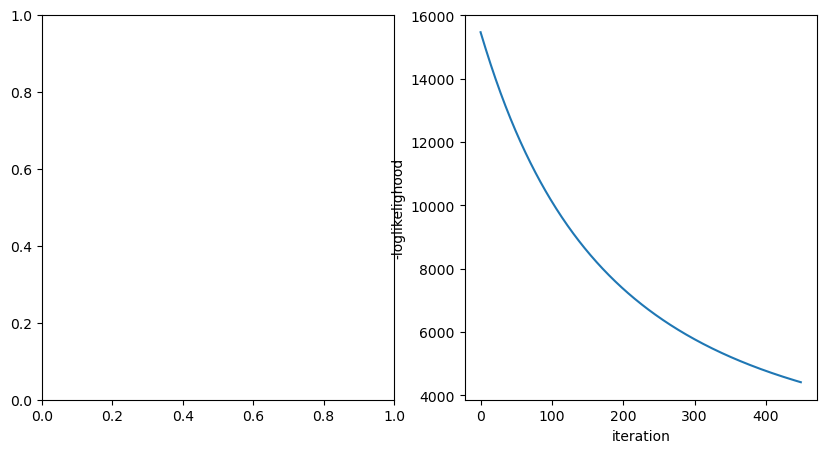

In [278]:
fig,ax=plt.subplots(1,2,figsize=(10,5))

ax[1].plot(np.arange(num_steps),losses)
ax[1].set_xlabel("iteration")
ax[1].set_ylabel("-loglikelighood")

In [ ]:
1.3/0.7

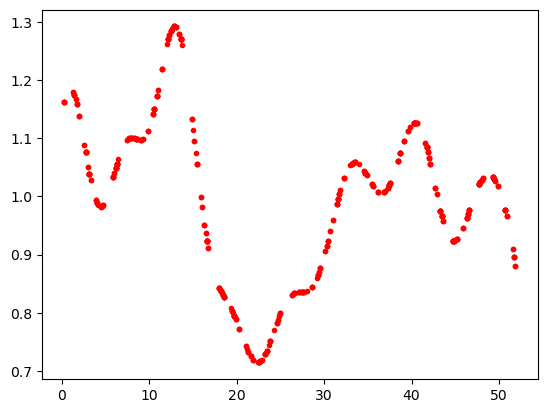

In [279]:
plt.plot(X, mean_prediction/(mean_prediction.mean()),"r.", label="Mean prediction")

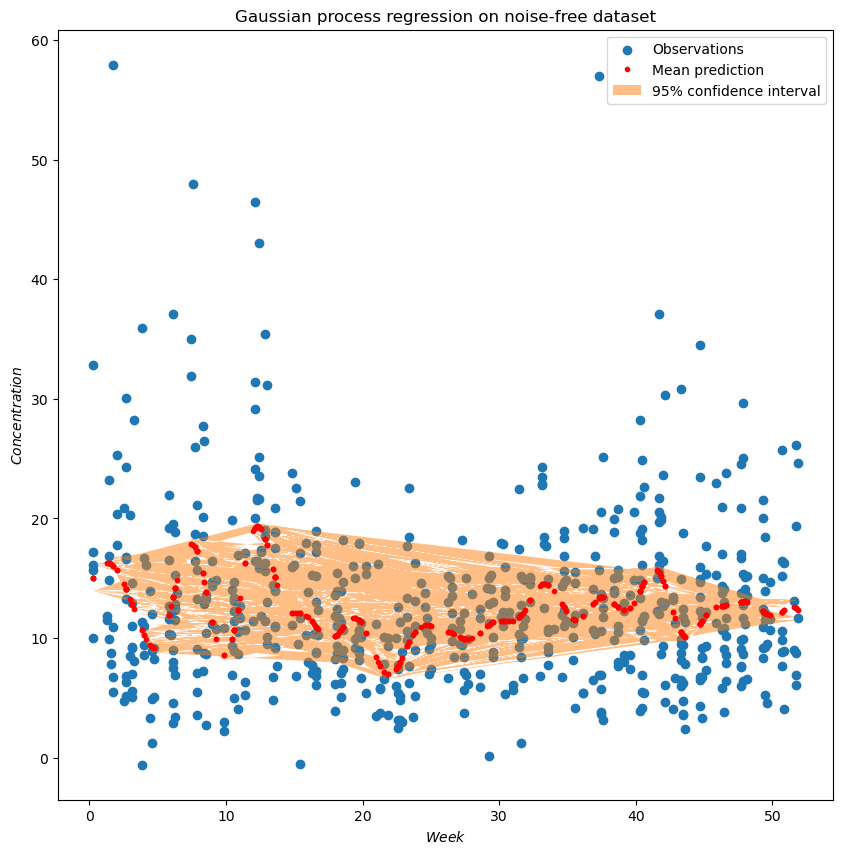

In [280]:
fig,ax=plt.subplots(1,1,figsize=(10,10))
mean_prediction, std_prediction = gpr(X_train)
mean_prediction=mean_prediction.detach().numpy()
std_prediction=std_prediction.detach().numpy()
X=data_train.corrected_week.values
ax.scatter(data_train.corrected_week.values, data_train.corrected_pm25.values, label="Observations")
ax.plot(X, mean_prediction,"r.", label="Mean prediction")
ax.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
ax.legend()
ax.set_xlabel("$Week$")
ax.set_ylabel("$Concentration$")
_ = plt.title("Gaussian process regression on noise-free dataset")

In [285]:

def plot(
    plot_observed_data=False,
    plot_predictions=False,
    n_prior_samples=0,
    model=None,
    kernel=None,
    n_test=500,
    ax=None,
    maxx=12
):

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    if plot_observed_data:
        ax.plot(X.numpy(), y.numpy(), "kx")
    if plot_predictions:
        Xtest = torch.linspace(-0.1,maxx, n_test)  # test inputs
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.GPRegression:
                mean, cov = model(Xtest, full_cov=True)
            else:
                mean, cov = model(Xtest, full_cov=True, noiseless=False)
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        ax.plot(Xtest.numpy(), mean.numpy(), "r", lw=2)  # plot the mean
        ax.fill_between(
            Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
            (mean - 2.0 * sd).numpy(),
            (mean + 2.0 * sd).numpy(),
            color="C0",
            alpha=0.3,
        )
    if n_prior_samples > 0:  # plot samples from the GP prior
        Xtest = torch.linspace(-0.1,maxx, n_test)  # test inputs
        noise = (
            model.noise
            if type(model) != gp.models.VariationalSparseGP
            else model.likelihood.variance
        )
        cov = kernel.forward(Xtest) + noise.expand(n_test).diag()
        samples = dist.MultivariateNormal(
            torch.zeros(n_test), covariance_matrix=cov
        ).sample(sample_shape=(n_prior_samples,))
        ax.plot(Xtest.numpy(), samples.numpy().T, lw=2, alpha=0.4)

    ax.set_xlim(-0.1,maxx)


Text(0, 0.5, '-loglikelighood')

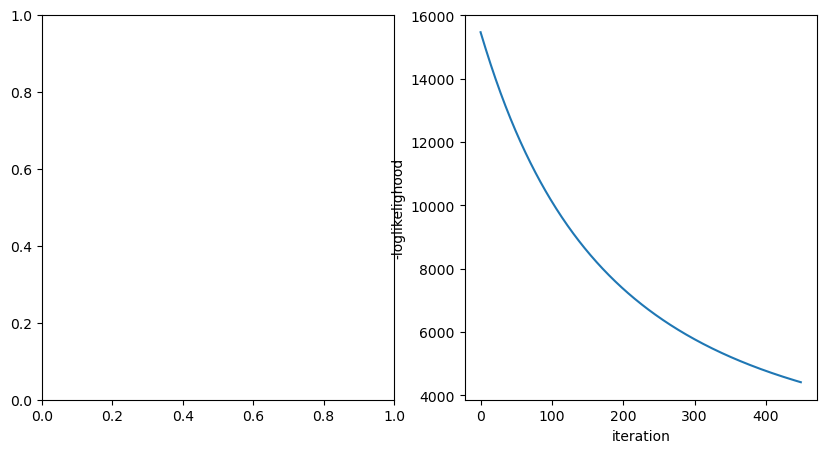

In [287]:
fig,ax=plt.subplots(1,2,figsize=(10,5))

ax[1].plot(np.arange(num_steps),losses)
ax[1].set_xlabel("iteration")
ax[1].set_ylabel("-loglikelighood")

In [474]:
resolution=250
A=np.zeros((len(data_test.bnr.unique()),resolution))
k=0
x=np.arange(0,51)
for i in data_test.bnr.unique():
    x=np.linspace(data_test.groupby("bnr").corrected_week.first().round(0).astype(int)[103]-26,data_test.groupby("bnr").corrected_week.first().round(0).astype(int)[103]+52,resolution)
    x0=np.where((x<0) ,52-x,x)
    x1=np.where((104>x0) &(x>52),(x-52),x0)
    x2=np.where((104<x1) ,(x1-104),x1)
    time=torch.tensor(x2).float()
    norm=np.array([25,51,77,103])[:data_test.loc[data_test.bnr==i,"corrected_week"].values.shape[0]]
    for j in range(time.size()[0]):
        A[k,j]=torch.sum(torch.tensor(stats.norm.pdf(np.abs(j-norm), 0, 39)/np.sum(stats.norm.pdf(np.abs(j-norm), 0, 39)))*torch.tensor(data_test.loc[data_test.bnr==i,"corrected_pm25"].values)*gpr(time.float())[0][j]/gpr(torch.tensor(data_test.loc[data_test.bnr==i,"corrected_week"].values).float())[0]).detach().numpy()
    k=k+1

In [489]:
m6_pm25_mean.shape

(389,)

In [491]:
m6_pm25_mean_test=pd.DataFrame(A).loc[:,:int(resolution*1/3)].mean(axis=1)
m6_pm25_std_test=pd.DataFrame(A).loc[:,:int(resolution*1/3)].std(axis=1)
m12_pm25_mean_test=pd.DataFrame(A).loc[:,int(resolution*1/3):int(resolution*2/3)].mean(axis=1)
m12_pm25_std_test=pd.DataFrame(A).loc[:,int(resolution*1/3):int(resolution*2/3)].std(axis=1)
m18_pm25_mean_test=pd.DataFrame(A).loc[:,int(resolution*2/3):].mean(axis=1)
m18_pm25_std_test=pd.DataFrame(A).loc[:,int(resolution*2/3):].std(axis=1)

In [493]:
np.sum(m12_pm25_mean-m6_pm25_mean)/m6_pm25_mean.shape,np.sum(m18_pm25_mean-m6_pm25_mean)/m6_pm25_mean.shape,np.sum(m12_pm25_mean-m18_pm25_mean)/m6_pm25_mean.shape

(array([0.08335551]), array([0.06077757]), array([0.02257794]))

In [495]:
Data_PM_test=pd.DataFrame([m6_pm25_mean_test,m12_pm25_mean_test,m18_pm25_mean_test,m6_pm25_std_test,m12_pm25_std_test,m18_pm25_std_test],index=["mean_month6","mean_month12","mean_month18","std_month6","std_month12","std_month18"]).T

In [497]:
Data_PM_test=Data_PM_test.set_index(data_test.bnr.unique())

In [499]:
resolution=250
A_all=np.zeros((len(data.bnr.unique()),resolution))
k=0
time1=np.linspace(1,78,resolution)
for i in data.bnr.unique():
    x=np.linspace(data.groupby("bnr").corrected_week.first().round(0).astype(int)[i]-26,data.groupby("bnr").corrected_week.first().round(0).astype(int)[i]+52,resolution)
    x0=np.where((x<0) ,52+x,x)
    x1=np.where((104>x0) &(x>52),(x-52),x0)
    x2=np.where((104<x1) ,(x1-104),x1)
    time=torch.tensor(x2).float()
    norm=np.array([25,51,77,103])[:data.loc[data.bnr==i,"corrected_week"].values.shape[0]]
    for j in range(time.size()[0]):
        A_all[k,j]=torch.sum(torch.tensor(stats.norm.pdf(np.abs(time1[j]-norm), 0, 39)/np.sum(stats.norm.pdf(np.abs(time1[j]-norm), 0, 39)))*torch.tensor(data.loc[data.bnr==i,"corrected_pm25"].values)*gpr(time.float())[0][j]/gpr(torch.tensor(data.loc[data.bnr==i,"corrected_week"].values).float())[0]).detach().numpy()
    k=k+1

In [500]:
x=np.linspace(data.groupby("bnr").corrected_week.first().round(0).astype(int)[i]-26,data.groupby("bnr").corrected_week.first().round(0).astype(int)[i]+52,resolution)
x0=np.where((x<0) ,52+x,x)
x1=np.where((104>x0) &(x>52),(x-52),x0)
x2=np.where((104<x1) ,(x1-104),x1)
time=torch.tensor(x2).float()
gpr(time.float())[0]

tensor([12.0076, 12.3313, 12.7399, 13.1259, 13.4006, 13.4968, 13.4079, 13.1742,
        12.8847, 12.6454, 12.5698, 12.7308, 13.1451, 13.7698, 14.4929, 15.1724,
        15.6484, 15.7996, 15.5568, 14.9326, 14.0106, 12.9396, 11.8837, 11.0102,
        10.4326, 10.2056, 10.3110, 10.6730, 11.1848, 11.7337, 12.2294, 12.6161,
        12.8834, 13.0411, 13.1286, 13.1677, 13.1757, 13.1712, 13.1262, 13.0326,
        12.8816, 12.6826, 12.4645, 12.2627, 12.1314, 12.1002, 12.1863, 12.3769,
        12.6348, 12.8873, 13.0607, 13.0804, 16.1294, 16.5288, 16.7181, 16.7107,
        16.5189, 16.1513, 15.6131, 14.9100, 14.0559, 13.0815, 12.0418, 11.0196,
        10.1222,  9.4703,  9.1800,  9.3402,  9.9892, 11.0978, 12.5608, 14.2038,
        15.8034, 17.1204, 17.9400, 18.1115, 17.5798, 16.4028, 14.7499, 12.8774,
        11.0907,  9.6919,  8.9279,  8.9432,  9.7533, 11.2377, 13.1604, 15.2136,
        17.0736, 18.4627, 19.1986, 19.2235, 18.6093, 17.5292, 16.2132, 14.8961,
        13.7650, 12.9272, 12.4005, 12.12

In [501]:
x1


array([36.        , 36.31325301, 36.62650602, 36.93975904, 37.25301205,
       37.56626506, 37.87951807, 38.19277108, 38.5060241 , 38.81927711,
       39.13253012, 39.44578313, 39.75903614, 40.07228916, 40.38554217,
       40.69879518, 41.01204819, 41.3253012 , 41.63855422, 41.95180723,
       42.26506024, 42.57831325, 42.89156627, 43.20481928, 43.51807229,
       43.8313253 , 44.14457831, 44.45783133, 44.77108434, 45.08433735,
       45.39759036, 45.71084337, 46.02409639, 46.3373494 , 46.65060241,
       46.96385542, 47.27710843, 47.59036145, 47.90361446, 48.21686747,
       48.53012048, 48.84337349, 49.15662651, 49.46987952, 49.78313253,
       50.09638554, 50.40963855, 50.72289157, 51.03614458, 51.34939759,
       51.6626506 , 51.97590361,  0.28915663,  0.60240964,  0.91566265,
        1.22891566,  1.54216867,  1.85542169,  2.1686747 ,  2.48192771,
        2.79518072,  3.10843373,  3.42168675,  3.73493976,  4.04819277,
        4.36144578,  4.6746988 ,  4.98795181,  5.30120482,  5.61

In [519]:
m6_pm25_mean=pd.DataFrame(A_all).loc[:,:int(resolution*1/3)].mean(axis=1)
m6_pm25_std=pd.DataFrame(A_all).loc[:,:int(resolution*1/3)].std(axis=1)
m12_pm25_mean=pd.DataFrame(A_all).loc[:,int(resolution*1/3):int(resolution*2/3)].mean(axis=1)
m12_pm25_std=pd.DataFrame(A_all).loc[:,int(resolution*1/3):int(resolution*2/3)].std(axis=1)
m18_pm25_mean=pd.DataFrame(A_all).loc[:,int(resolution*2/3):].mean(axis=1)
m18_pm25_std=pd.DataFrame(A_all).loc[:,int(resolution*2/3):].std(axis=1)
Data_PM=pd.DataFrame([m6_pm25_mean,m12_pm25_mean,m18_pm25_mean,m6_pm25_std,m12_pm25_std,m18_pm25_std],index=["mean_month6","mean_month12","mean_month18","std_month6","std_month12","std_month18"]).T
Data_PM=Data_PM.set_index(data.bnr.unique())

In [616]:
Data_PM

,mean_month6,mean_month12,mean_month18,std_month6,std_month12,std_month18
1,8.144894,9.408362,10.043611,1.937130,1.280216,2.388740
3,78.836288,77.062273,70.445687,20.483184,8.898792,18.363150
5,11.136686,12.242172,12.580084,2.720601,1.579793,3.047871
7,47.158622,48.587654,49.382952,11.415411,5.654858,12.442124
8,6.109289,7.387525,9.124364,1.409351,1.070501,2.107492
...,...,...,...,...,...,...
446,23.760198,22.002400,19.260334,2.526735,5.766716,2.017530
449,14.952378,12.972562,14.182398,2.639001,2.645330,2.518492
450,18.462816,16.456219,18.450113,3.686495,2.704188,3.683190
451,18.081349,15.329746,18.081349,3.489472,2.224865,3.489472


In [618]:
Data_PM.to_excel("to_gaussion_pm25_all.xlsx")

In [523]:
hest_6=Data_PM.loc[pm_1.bnr]
hest_12=Data_PM.loc[pm_2.bnr]
hest_18=Data_PM.loc[pm_3.bnr]

In [525]:
pm_1=data_test.loc[data_test.maalnr==1]
pm_2=data_test.loc[data_test.maalnr==2]
pm_3=data_test.loc[data_test.maalnr==3]

In [526]:
p_12=np.polyfit(pm_2.corrected_pm25,hest_12.mean_month12,1)
p_6=np.polyfit(pm_1.corrected_pm25,hest_6.mean_month6,1)
p_18=np.polyfit(pm_3.corrected_pm25,hest_18.mean_month18,1)
pm_1=data_test.loc[data_test.maalnr==1]
pm_2=data_test.loc[data_test.maalnr==2]
pm_3=data_test.loc[data_test.maalnr==3]

In [529]:
gm = GaussianMixture(n_components=3, random_state=0).fit(pm.reshape(-1, 1))
gm2 = GaussianMixture(n_components=2, random_state=0).fit(pm.reshape(-1, 1))

C:\Users\michael.forsmann\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\michael.forsmann\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


In [530]:
pm=Data_PM.loc[:,["mean_month6","mean_month12","mean_month18"]].values.flatten()

In [533]:
import seaborn as sns
from sklearn.mixture import GaussianMixture

C:\Users\michael.forsmann\AppData\Local\Temp\ipykernel_2092\3990401101.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(value)
C:\Users\michael.forsmann\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\michael.forsmann\AppData\Local\Temp\ipykernel_2092\3990401101.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function 

<Axes: xlabel='mean_month18', ylabel='Density'>

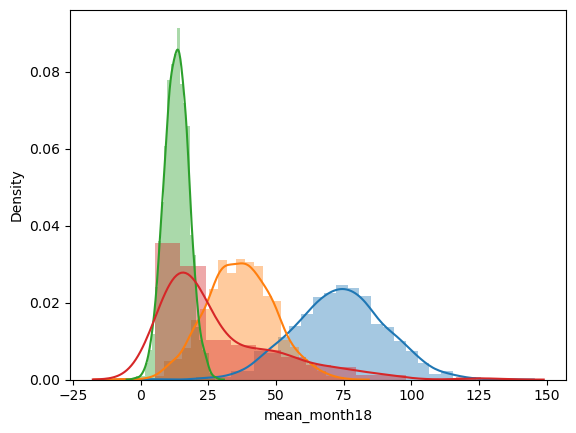

In [534]:
std1,std2,std3=np.sqrt(gm.covariances_).T[0][0]
mean1,mean2,mean3=gm.means_
value = np.random.normal(loc=mean1,scale=std1,size=1000)
value2 = np.random.normal(loc=mean2,scale=std2,size=1000)
value3= np.random.normal(loc=mean3,scale=std3,size=1000)

sns.distplot(value)
sns.distplot(value2)
sns.distplot(value3)
sns.distplot(hest_6.mean_month18)


In [536]:
data_somulative.to_excel("gassion_pm25.xlsx")

NameError: name 'data_somulative' is not defined

C:\Users\michael.forsmann\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\michael.forsmann\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\michael.forsmann\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\michael.forsmann\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

<Axes: xlabel='corrected_pm25', ylabel='Density'>

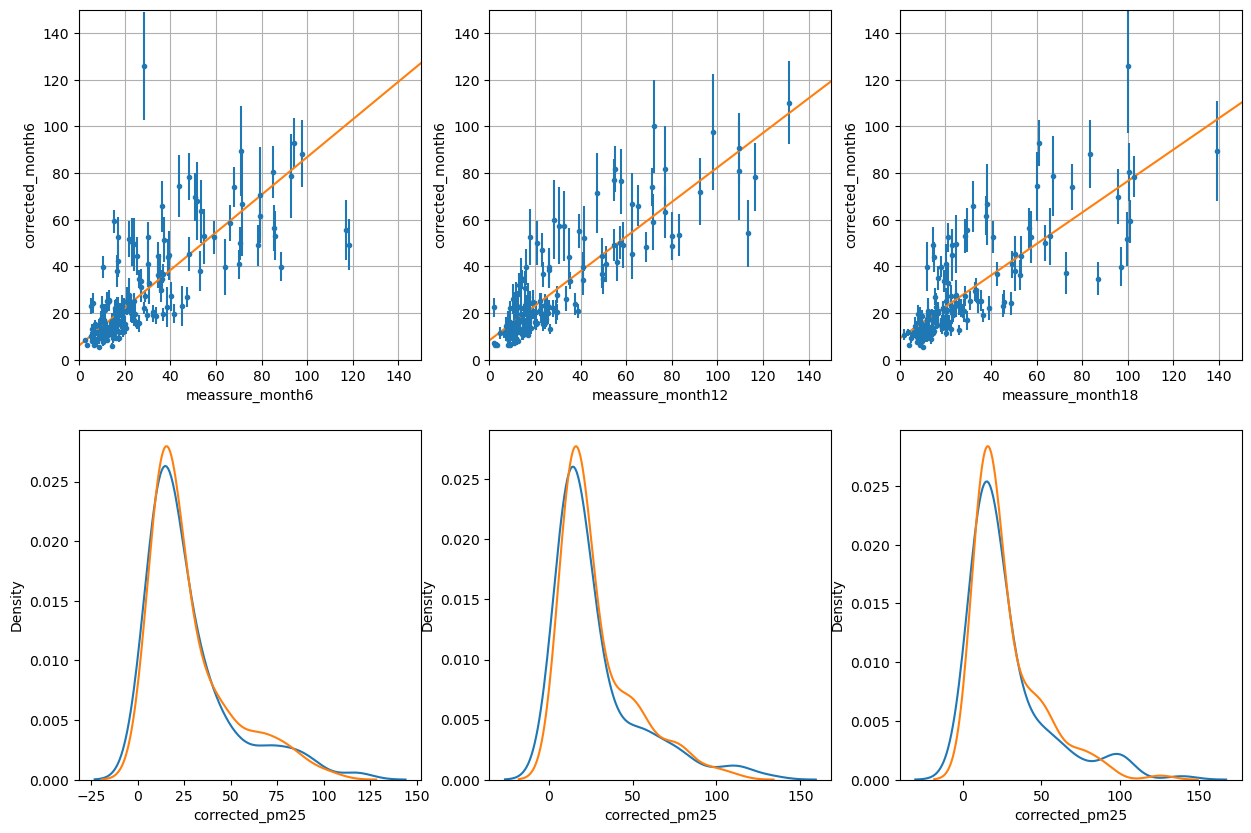

In [539]:
x=np.linspace(0,150)
fig,ax=plt.subplots(2,3,figsize=(15,10))
ax[0,0].errorbar(pm_1.corrected_pm25,hest_6.mean_month18,yerr=hest_6.std_month6,fmt='.')
ax[0,0].grid()
ax[0,0].plot(x,x*p_6[0]+p_6[1])
ax[0,1].errorbar(pm_2.corrected_pm25,hest_12.mean_month12,yerr=hest_12.std_month12,fmt='.')
ax[0,1].plot(x,x*p_12[0]+p_12[1])
ax[0,1].grid()
ax[0,2].errorbar(pm_3.corrected_pm25,hest_18.mean_month18,yerr=hest_18.std_month18,fmt='.')
ax[0,2].plot(x,x*p_18[0]+p_18[1])
ax[0,2].grid()
ax[0,0].set_xlim(0,150)
ax[0,0].set_ylim(0,150)
ax[0,1].set_xlim(0,150)
ax[0,1].set_ylim(0,150)
ax[0,2].set_xlim(0,150)
ax[0,2].set_ylim(0,150)
ax[0,0].set_xlabel("meassure_month6")
ax[0,1].set_xlabel("meassure_month12")
ax[0,2].set_xlabel("meassure_month18")
ax[0,0].set_ylabel("corrected_month6")
ax[0,1].set_ylabel("corrected_month6")
ax[0,2].set_ylabel("corrected_month6")
sns.kdeplot(pm_1.corrected_pm25,ax=ax[1,0])
sns.kdeplot(hest_6.mean_month6,ax=ax[1,0])
sns.kdeplot(pm_2.corrected_pm25,ax=ax[1,1])
sns.kdeplot(hest_12.mean_month12,ax=ax[1,1])
sns.kdeplot(pm_3.corrected_pm25,ax=ax[1,2])
sns.kdeplot(hest_18.mean_month18,ax=ax[1,2])

In [541]:
no2

,Unnamed: 0,cpnr,visit,batch_c,start_c,stop_c,batch_n,start_n,stop_n,no2,...,sample_time,day,Nox,no2_corrected,formaldehyd_corrected,sadto,week,month,year,10_week
0,0,1,1,Batch1,1999-09-02,1999-11-04,Batch 2,1999-04-20,1999-07-04,7.8,...,75,110,NaN,7.996002,19.366838,1999-04-20,16,4,1999,15.714286
1,1,1,4,NaN,NaT,NaT,Batch 7,1999-09-21,1999-11-04,6.8,...,44,264,NaN,5.976705,NaN,1999-09-21,38,9,1999,37.714286
2,2,1,2,Batch4,2000-03-21,2000-05-26,Batch 11,2000-03-16,2000-05-26,6.5,...,71,76,NaN,6.532343,14.787594,2000-03-16,11,3,2000,10.857143
3,3,1,3,Batch28,2001-06-20,2001-09-10,Batch 45,2001-06-20,2001-09-10,11.6,...,82,171,NaN,12.311922,18.872279,2001-06-20,25,6,2001,24.428571
4,5,3,1,NaN,NaT,NaT,Batch 2,1999-04-09,1999-06-29,30.5,...,81,99,NaN,32.211582,NaN,1999-04-09,14,4,1999,14.142857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
974,1403,450,1,Batch54,2002-05-23,2002-08-06,Batch 95,2002-05-23,2002-08-06,5.5,...,75,143,NaN,5.638206,21.436029,2002-05-23,21,5,2002,20.428571
975,1404,450,2,Batch67,2002-12-16,2003-03-12,Batch 121,2002-12-16,2003-03-12,5.3,...,86,350,NaN,5.738077,31.659954,2002-12-16,51,12,2002,50.000000
976,1405,450,3,Batch73,2003-06-29,2003-09-16,Batch 132,2003-06-29,2003-09-16,3.8,...,79,180,NaN,3.973603,22.071873,2003-06-29,26,6,2003,25.714286
977,1407,452,1,Batch59,2002-08-04,2002-10-13,Batch 105,2002-08-04,2002-10-13,10.8,...,70,216,NaN,10.800000,13.802774,2002-08-04,31,8,2002,30.857143


## chemical traning test split 

In [544]:
no2=no2.loc[no2.no2.isna()==0]
no2["10_week"]=no2.day/(7)

In [546]:
No2_train=no2.loc[no2.passive==0]
No2_test=no2.loc[no2.passive>0]
no2=no2.loc[no2.no2.isna()==0]

AttributeError: 'DataFrame' object has no attribute 'passive'

## NO2

In [568]:
pyro.clear_param_store()

rbf = gp.kernels.RBF(input_dim=1)

rbf.variance = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(0.01), torch.tensor(0.5)))

rbf.lengthscale = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(0.01), torch.tensor(0.5)))

x=torch.tensor(no2["10_week"].values).float()
y=torch.tensor(no2.no2_corrected.values).float()
gpr_no2 = gp.models.GPRegression(x,y, rbf)

optimizer = torch.optim.Adam(gpr_no2.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
locations = []
variances = []
lengthscales = []
noises = []
num_steps = 200
X123=[]
for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpr_no2.model, gpr_no2.guide)
    noises.append(gpr_no2.noise.item )
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    X123.append(torch.sqrt(torch.sum(((gpr(X_train.float())[0]-y_train)**2/len(X_train)))).detach().numpy())

Text(0, 0.5, '-loglikelighood')

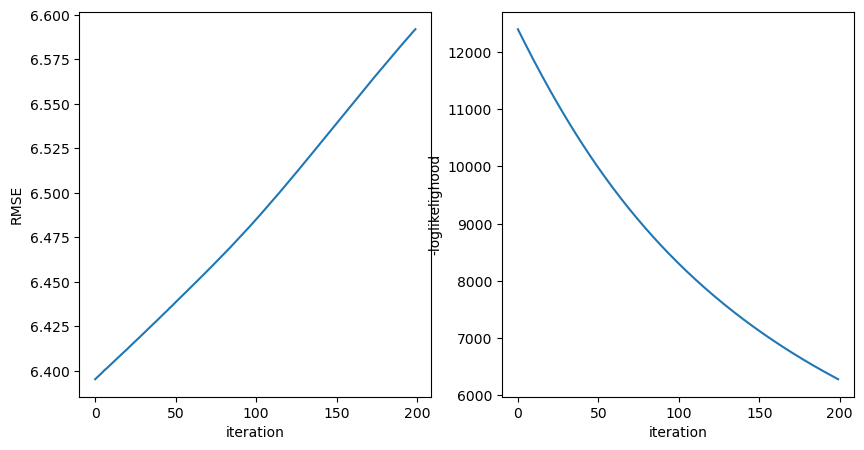

In [569]:
fig,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].plot(np.arange(num_steps),X123)
ax[0].set_xlabel("iteration")
ax[0].set_ylabel("RMSE")
ax[1].plot(np.arange(num_steps),losses)
ax[1].set_xlabel("iteration")
ax[1].set_ylabel("-loglikelighood")

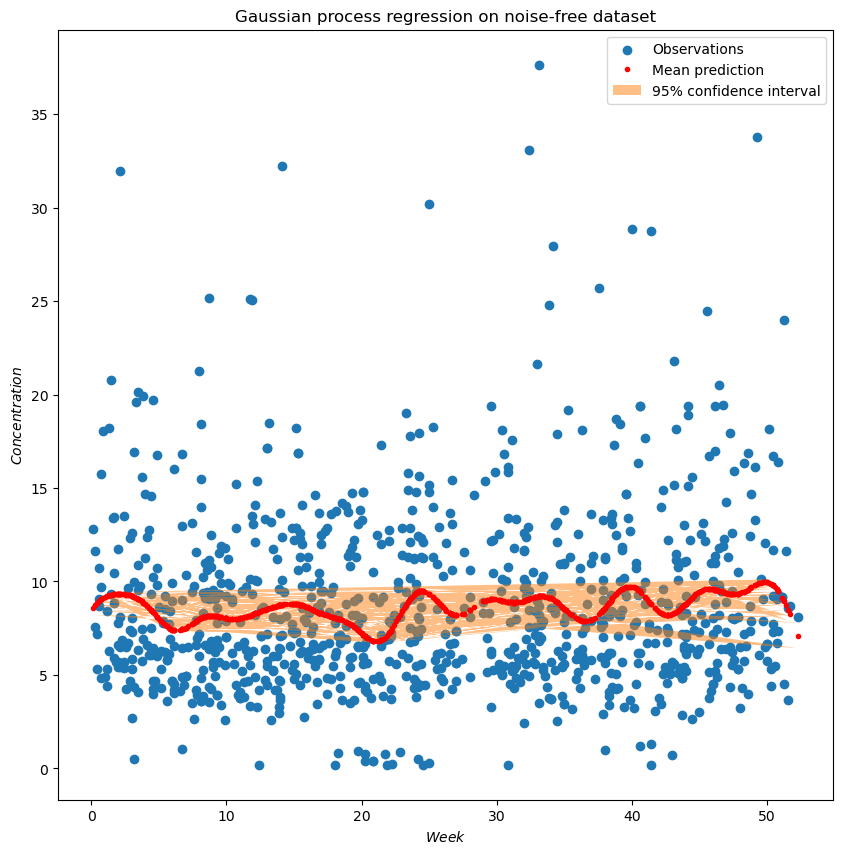

In [570]:
fig,ax=plt.subplots(1,1,figsize=(10,10))
mean_prediction, std_prediction = gpr_no2(torch.tensor(no2["10_week"].values).float())
mean_prediction=mean_prediction.detach().numpy()
std_prediction=std_prediction.detach().numpy()
X=no2["10_week"].values
ax.scatter(no2["10_week"].values, no2.no2_corrected.values, label="Observations")
ax.plot(X, mean_prediction,"r.", label="Mean prediction")
ax.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
ax.legend()
ax.set_xlabel("$Week$")
ax.set_ylabel("$Concentration$")
_ = plt.title("Gaussian process regression on noise-free dataset")

In [574]:
torch.tensor(no2.loc[no2.cpnr==i,"no2_corrected"].values)*gpr(time.float())[0][j]/gpr(torch.tensor(no2.loc[no2.cpnr==i,"10_week"].values).float())[0]

tensor([], dtype=torch.float64, grad_fn=<DivBackward0>)

In [576]:
no2

,Unnamed: 0,cpnr,visit,batch_c,start_c,stop_c,batch_n,start_n,stop_n,no2,...,sample_time,day,Nox,no2_corrected,formaldehyd_corrected,sadto,week,month,year,10_week
0,0,1,1,Batch1,1999-09-02,1999-11-04,Batch 2,1999-04-20,1999-07-04,7.8,...,75,110,NaN,7.996002,19.366838,1999-04-20,16,4,1999,15.714286
1,1,1,4,NaN,NaT,NaT,Batch 7,1999-09-21,1999-11-04,6.8,...,44,264,NaN,5.976705,NaN,1999-09-21,38,9,1999,37.714286
2,2,1,2,Batch4,2000-03-21,2000-05-26,Batch 11,2000-03-16,2000-05-26,6.5,...,71,76,NaN,6.532343,14.787594,2000-03-16,11,3,2000,10.857143
3,3,1,3,Batch28,2001-06-20,2001-09-10,Batch 45,2001-06-20,2001-09-10,11.6,...,82,171,NaN,12.311922,18.872279,2001-06-20,25,6,2001,24.428571
4,5,3,1,NaN,NaT,NaT,Batch 2,1999-04-09,1999-06-29,30.5,...,81,99,NaN,32.211582,NaN,1999-04-09,14,4,1999,14.142857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
974,1403,450,1,Batch54,2002-05-23,2002-08-06,Batch 95,2002-05-23,2002-08-06,5.5,...,75,143,NaN,5.638206,21.436029,2002-05-23,21,5,2002,20.428571
975,1404,450,2,Batch67,2002-12-16,2003-03-12,Batch 121,2002-12-16,2003-03-12,5.3,...,86,350,NaN,5.738077,31.659954,2002-12-16,51,12,2002,50.000000
976,1405,450,3,Batch73,2003-06-29,2003-09-16,Batch 132,2003-06-29,2003-09-16,3.8,...,79,180,NaN,3.973603,22.071873,2003-06-29,26,6,2003,25.714286
977,1407,452,1,Batch59,2002-08-04,2002-10-13,Batch 105,2002-08-04,2002-10-13,10.8,...,70,216,NaN,10.800000,13.802774,2002-08-04,31,8,2002,30.857143


In [578]:
no2.loc[no2.cpnr==i,"10_week"].values.shape[0]

0

In [580]:
resolution=250
A_no2=np.zeros((len(no2.cpnr.unique()),resolution))
k=0
x=np.arange(0,51)
for i in no2.cpnr.unique():
    x=np.linspace(no2.groupby("cpnr")["10_week"].first().round(0).astype(int)[103]-26,no2.groupby("cpnr")["10_week"].first().round(0).astype(int)[103]+52,resolution)
    x0=np.where((x<0) ,52-x,x)
    x1=np.where((104>x0) &(x>52),(x-52),x0)
    x2=np.where((104<x1) ,(x1-104),x1)
    time=torch.tensor(x2).float()
    norm=np.array([25,51,77,103,129])[:no2.loc[no2.cpnr==i,"10_week"].values.shape[0]]
    for j in range(time.size()[0]):
        A_no2[k,j]=torch.sum(torch.tensor(stats.norm.pdf(np.abs(j-norm), 0, 39)/np.sum(stats.norm.pdf(np.abs(j-norm), 0, 39)))*torch.tensor(no2.loc[no2.cpnr==i,"10_week"].values)*gpr_no2(time.float())[0][j]/gpr_no2(torch.tensor(no2.loc[no2.cpnr==i,"10_week"].values).float())[0]).detach().numpy()
    k=k+1

In [612]:
x2

array([17.        , 17.31325301, 17.62650602, 17.93975904, 18.25301205,
       18.56626506, 18.87951807, 19.19277108, 19.5060241 , 19.81927711,
       20.13253012, 20.44578313, 20.75903614, 21.07228916, 21.38554217,
       21.69879518, 22.01204819, 22.3253012 , 22.63855422, 22.95180723,
       23.26506024, 23.57831325, 23.89156627, 24.20481928, 24.51807229,
       24.8313253 , 25.14457831, 25.45783133, 25.77108434, 26.08433735,
       26.39759036, 26.71084337, 27.02409639, 27.3373494 , 27.65060241,
       27.96385542, 28.27710843, 28.59036145, 28.90361446, 29.21686747,
       29.53012048, 29.84337349, 30.15662651, 30.46987952, 30.78313253,
       31.09638554, 31.40963855, 31.72289157, 32.03614458, 32.34939759,
       32.6626506 , 32.97590361, 33.28915663, 33.60240964, 33.91566265,
       34.22891566, 34.54216867, 34.85542169, 35.1686747 , 35.48192771,
       35.79518072, 36.10843373, 36.42168675, 36.73493976, 37.04819277,
       37.36144578, 37.6746988 , 37.98795181, 38.30120482, 38.61

In [581]:
m6_no2_mean=pd.DataFrame(A_no2).loc[:,:int(resolution*1/3)].mean(axis=1)
m6_no2_std=pd.DataFrame(A_no2).loc[:,:int(resolution*1/3)].std(axis=1)
m12_no2_mean=pd.DataFrame(A_no2).loc[:,int(resolution*1/3):int(resolution*2/3)].mean(axis=1)
m12_no2_std=pd.DataFrame(A_no2).loc[:,int(resolution*1/3):int(resolution*2/3)].std(axis=1)
m18_no2_mean=pd.DataFrame(A_no2).loc[:,int(resolution*2/3):].mean(axis=1)
m18_no2_std=pd.DataFrame(A_no2).loc[:,int(resolution*2/3):].std(axis=1)
Data_no2=pd.DataFrame([m6_no2_mean,m12_no2_mean,m18_no2_mean,m6_no2_std,m12_no2_std,m18_no2_std],index=["mean_month6","mean_month12","mean_month18","std_month6","std_month12","std_month18"]).T
Data_no2=Data_no2.set_index(no2.cpnr.unique())

In [595]:
no2_1=no2.loc[no2.visit==1]
no2_2=no2.loc[no2.visit==2]
no2_3=no2.loc[no2.visit==3]

In [597]:
no2.columns

Index(['Unnamed: 0', 'cpnr', 'visit', 'batch_c', 'start_c', 'stop_c',
       'batch_n', 'start_n', 'stop_n', 'no2', 'nox', 'formaldehyd', 'acetald',
       'acetone', 'sample_time', 'day', 'Nox', 'no2_corrected',
       'formaldehyd_corrected', 'sadto', 'week', 'month', 'year', '10_week'],
      dtype='object')

In [599]:
hest_6_no2=Data_no2.loc[no2_1.cpnr]
hest_12_no2=Data_no2.loc[no2_2.cpnr]
hest_18_no2=Data_no2.loc[no2_3.cpnr]

In [602]:
p_12_no2=np.polyfit(no2_2.no2_corrected,hest_12_no2.mean_month12,1)
p_6_no2=np.polyfit(no2_1.no2_corrected,hest_6_no2.mean_month6,1)
p_18_no2=np.polyfit(no2_3.no2_corrected,hest_18_no2.mean_month18,1)


C:\Users\michael.forsmann\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\michael.forsmann\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\michael.forsmann\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\michael.forsmann\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

<Axes: xlabel='mean_month18', ylabel='Density'>

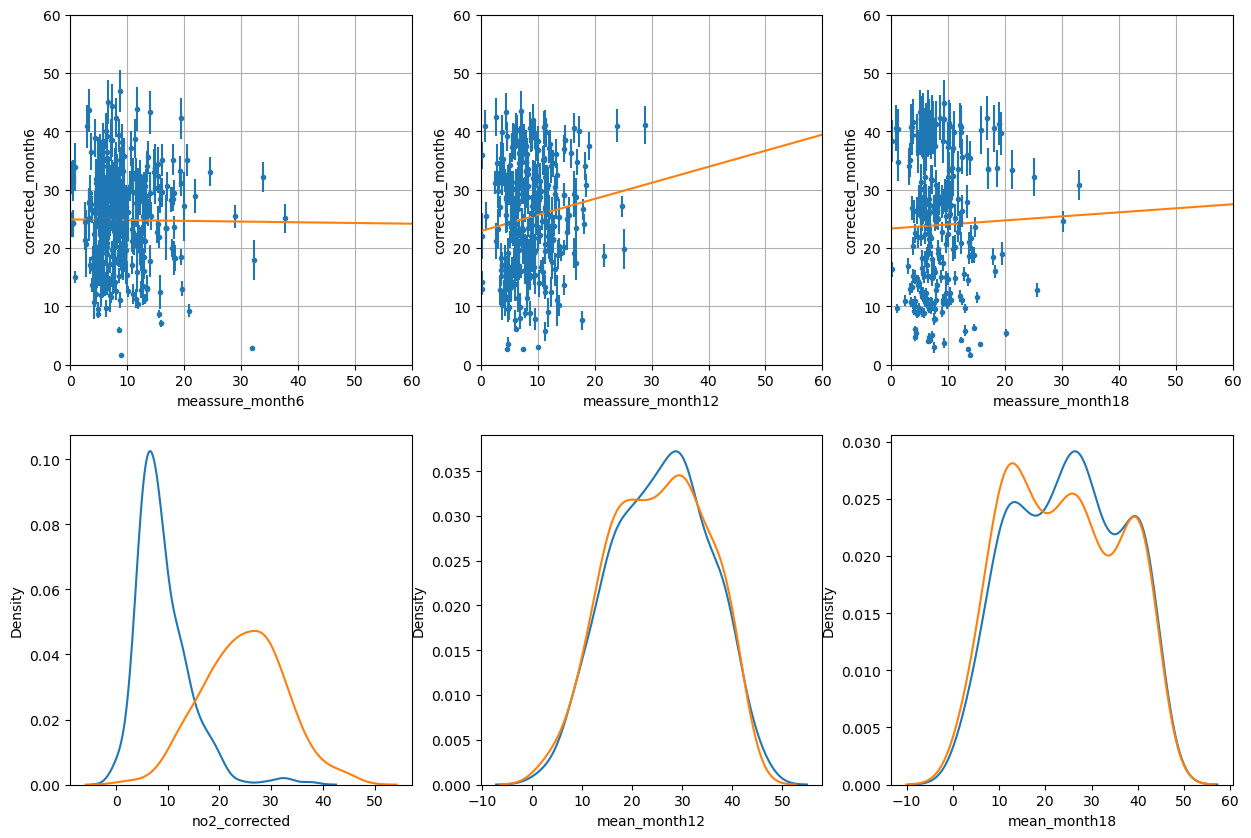

In [606]:
N=60
x=np.linspace(0,N)
fig,ax=plt.subplots(2,3,figsize=(15,10))
ax[0,0].errorbar(no2_1.no2_corrected,hest_6_no2.mean_month6,yerr=hest_6_no2.std_month6,fmt='.')
ax[0,0].grid()
ax[0,0].plot(x,x*p_6_no2[0]+p_6_no2[1])
ax[0,1].errorbar(no2_2.no2_corrected,hest_12_no2.mean_month12,yerr=hest_12_no2.std_month12,fmt='.')
ax[0,1].plot(x,x*p_12_no2[0]+p_12_no2[1])
ax[0,1].grid()
ax[0,2].errorbar(no2_3.no2_corrected,hest_18_no2.mean_month18,yerr=hest_18_no2.std_month18,fmt='.')
ax[0,2].plot(x,x*p_18_no2[0]+p_18_no2[1])
ax[0,2].grid()
ax[0,0].set_xlim(0,N)
ax[0,0].set_ylim(0,N)
ax[0,1].set_xlim(0,N)
ax[0,1].set_ylim(0,N)
ax[0,2].set_xlim(0,N)
ax[0,2].set_ylim(0,N)
ax[0,0].set_xlabel("meassure_month6")
ax[0,1].set_xlabel("meassure_month12")
ax[0,2].set_xlabel("meassure_month18")
ax[0,0].set_ylabel("corrected_month6")
ax[0,1].set_ylabel("corrected_month6")
ax[0,2].set_ylabel("corrected_month6")
sns.kdeplot(no2_1.no2_corrected,ax=ax[1,0])
sns.kdeplot(hest_6_no2.mean_month6,ax=ax[1,0])
sns.kdeplot(hest_6_no2.mean_month12,ax=ax[1,1])
sns.kdeplot(hest_12_no2.mean_month12,ax=ax[1,1])
sns.kdeplot(hest_6_no2.mean_month18,ax=ax[1,2])
sns.kdeplot(hest_18_no2.mean_month18,ax=ax[1,2])

In [614]:
Data_no2.to_excel("gaussion_no2.xlsx")

<Axes: >

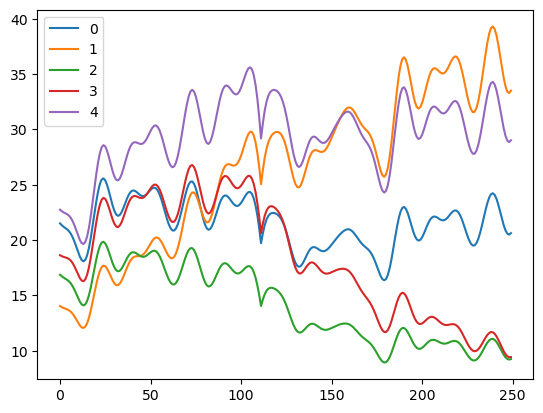

In [610]:
pd.DataFrame(A_no2).T.iloc[:,:5].plot()